In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 120/120 [01:18<00:00,  1.53it/s]


Image 2220535774749563.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2028746107282244.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2247574212062568.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2098827763593413.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2161533847315648.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2121626881312157.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 2220242451445399.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/green_images_Diamond_bar
Image 21098553691887

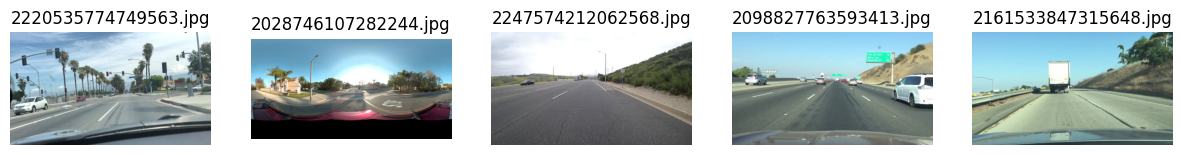

In [13]:
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

MAPILLARY_TOKEN = "MLY|9796955727030398|79bd541e357958deb337d6a6f6ea3f7b"

bbox = [-117.937488,33.977763,-117.685146,34.080052]  # Longitude, Latitude
DOWNLOAD_PATH = "/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data"
GREEN_IMAGES_PATH = os.path.join(DOWNLOAD_PATH, "green_images_Diamond_bar")

def search_mapillary_images(bbox, token, limit=20):
    url = "https://graph.mapillary.com/images"
    params = {
        "access_token": token,
        "bbox": ",".join(map(str, bbox)),
        "fields": "id,thumb_1024_url",
        "limit": limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data.get("data", [])

def download_images(image_data, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for item in tqdm(image_data):
        img_url = item.get("thumb_1024_url")
        img_id = item.get("id")
        if img_url and img_id:
            img_data = requests.get(img_url).content
            with open(f"{save_dir}/{img_id}.jpg", "wb") as f:
                f.write(img_data)

def has_green(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = (25, 30, 30)
        upper_green = (95, 255, 255)
        mask = cv2.inRange(hsv, lower_green, upper_green)
        green_pixels = cv2.countNonZero(mask)
        threshold = img.shape[0] * img.shape[1] * 0.005
        return green_pixels > threshold
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return False

def filter_images_by_green(image_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            if has_green(image_path):
                output_path = os.path.join(output_folder, filename)
                os.rename(image_path, output_path)
                print(f"Image {filename} contains green and moved to {output_folder}")
            else:
                os.remove(image_path)
                print(f"Image {filename} does not contain significant green and deleted")

def show_filtered_samples(folder, num=5):
    files = glob.glob(f"{folder}/*.jpg")[:num]
    if not files:
        print(f"No images found in {folder}.")
        return
    plt.figure(figsize=(15, 5))
    for i, fpath in enumerate(files):
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(fpath))
        plt.axis("off")
    plt.show()

# Search and download
images = search_mapillary_images(bbox, MAPILLARY_TOKEN, limit=120)
download_images(images, save_dir=DOWNLOAD_PATH)

# filter
filter_images_by_green(image_folder=DOWNLOAD_PATH, output_folder=GREEN_IMAGES_PATH)

# Display filtered image
show_filtered_samples(folder=GREEN_IMAGES_PATH)